In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wsi.utils import processed_data_path, raw_data_path
from wsi.mapping.iso_name import ISO_NAME

index_baseline = pd.read_csv(processed_data_path("womens_safety_index_baseline.csv"))
path = raw_data_path("violence", "WorldBank_GenderStatistics_IntimatePartner.csv")
df = pd.read_csv(path)
df = df.iloc[:530, :] # delete trailing na rows

# DHS IPV data
SG.VAW.IPVE.ZS
Proportion of women who have ever experienced intimate partner violence (% of ever-married women ages 15-49)

In [2]:
df_filtered = df[df['Series Code'] == 'SG.VAW.IPVE.ZS']
df_pivot = df_filtered.set_index('Country Code').drop(columns=['Series Name', 'Series Code', 'Country Name'])
df_pivot.columns = df_pivot.columns.str.extract(r'(\d{4})')[0].astype(int)
df_pivot = df_pivot.reset_index()  # Make Country Code a column
df_long = df_pivot.melt(id_vars='Country Code', var_name='Year', value_name='IPV').rename(columns={'Country Code':'ISO_code'})
df_long.head()

,ISO_code,Year,IPV
0,AFG,1960,NaN
1,ALB,1960,NaN
2,DZA,1960,NaN
3,ASM,1960,NaN
4,AND,1960,NaN


In [3]:
merged = pd.merge(df_long, index_baseline,
                  on=['ISO_code', 'Year'],
                  how='inner')
merged = merged.dropna(subset=['IPV'])

merged['IPV']  = pd.to_numeric(merged['IPV'],  errors='coerce')
merged['Year'] = pd.to_numeric(merged['Year'], errors='coerce')
merged = merged.dropna(subset=['IPV', "WSI (Baseline)"])
merged.head()

,ISO_code,Year,IPV,Education,Employment,Parliamentary Representation,Poverty,Legal Protection Index,Son Bias,Maternal Mortality,...,Child Marriage (score),Access Water Sanitation (score),Access Electricity (score),Cell Phone Use (score),Financial Inclusion (score),Equity,Protection,Resilience,WSI (Baseline),Economy
978,KHM,2000,17.1,0.604000,82.964708,5.464481,29.534,0.625000,105.0,605.58753,...,0.676240,0.173056,0.159274,0.003372,0.029418,0.493565,0.708584,0.091280,0.317227,Cambodia
985,COL,2000,40.7,0.984572,52.632567,12.167300,17.500,0.562500,104.7,92.63503,...,0.720627,0.792098,0.951613,0.018016,0.247572,0.517987,0.847495,0.502325,0.604153,Colombia
1020,HTI,2000,26.1,0.777399,38.603468,2.727273,29.200,0.614583,102.7,399.73795,...,0.685379,0.236444,0.331653,0.002060,0.204406,0.421615,0.592099,0.193641,0.364280,Haiti
1377,DOM,2002,19.2,1.061871,46.080669,14.525140,7.600,0.656250,104.9,70.34202,...,0.462141,0.808855,0.896169,0.060533,0.368757,0.563027,0.692923,0.533578,0.592658,Dominican Republic
1606,KEN,2003,42.9,0.787024,69.929983,7.142857,36.700,0.500000,101.8,525.45634,...,0.678851,0.302997,0.153226,0.014748,0.386921,0.457077,0.680298,0.214473,0.405528,Kenya


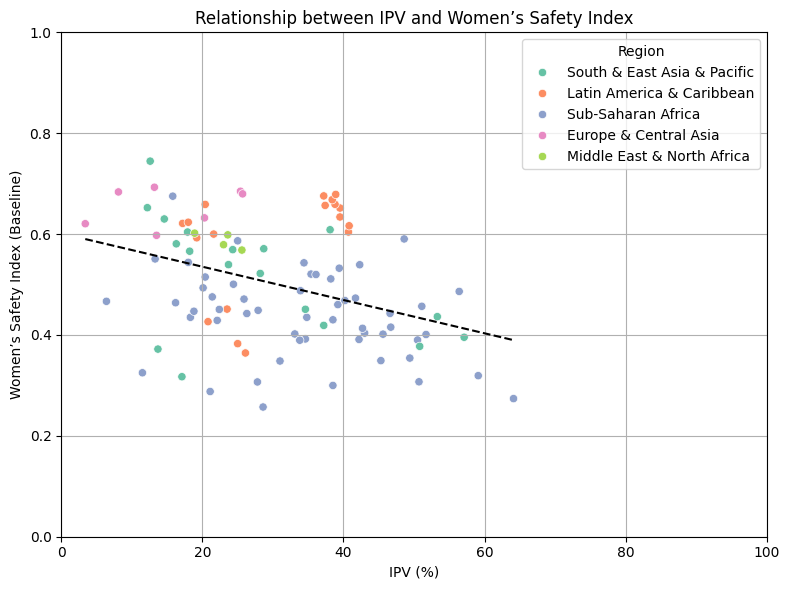

In [4]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged,
    x='IPV',
    y='WSI (Baseline)',
    hue='Region',
    palette='Set2',  # or use another palette like 'Set2', 'Dark2', etc.
    alpha=1
)

# Linear fit
m, b = np.polyfit(merged['IPV'], merged['WSI (Baseline)'], 1)
x = np.array([merged['IPV'].min(), merged['IPV'].max()])
plt.plot(x, m * x + b, linestyle='--', color='black', label=f'Fit: y={m:.2f}x+{b:.1f}')

plt.xlabel('IPV (%)')
plt.ylabel("Women’s Safety Index (Baseline)")
plt.title('Relationship between IPV and Women’s Safety Index')
#plt.legend()
plt.grid(True)

plt.xlim(0, 100)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [5]:
ipv_avg = (
    df_long
    .assign(IPV=lambda df: pd.to_numeric(df['IPV'], errors='coerce'))
    .dropna(subset=['IPV'])
    .groupby('ISO_code', as_index=False)['IPV']
    .mean()
    .rename(columns={'IPV': 'Avg_IPV'})
)

wsi_avg = (
    index_baseline
    .assign(WSI=lambda df: pd.to_numeric(df["WSI (Baseline)"], errors='coerce'))
    .dropna(subset=['WSI'])
    .groupby('ISO_code', as_index=False)['WSI']
    .mean()
    .rename(columns={'WSI': 'Avg_WSI'})
)

summary = pd.merge(ipv_avg, wsi_avg, on='ISO_code', how='inner')
summary["Economy"] = summary["ISO_code"].map(ISO_NAME)
summary.head()

,ISO_code,Avg_IPV,Avg_WSI,Economy
0,AFG,50.8,0.319419,Afghanistan
1,AGO,33.9,0.466165,Angola
2,ARM,8.1,0.643111,Armenia
3,AZE,13.5,0.631481,Azerbaijan
4,BDI,46.7,0.372348,Burundi


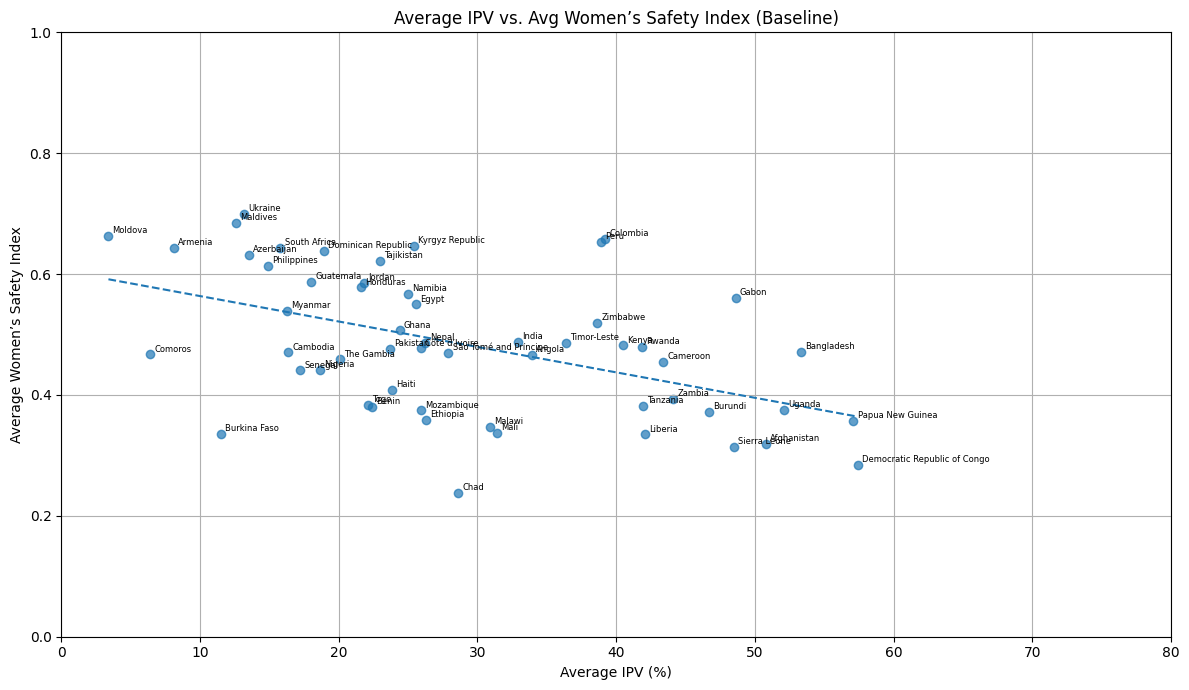

In [6]:
plt.figure(figsize=(12, 7))
plt.scatter(summary['Avg_IPV'], summary['Avg_WSI'], alpha=0.7)

for _, row in summary.iterrows():
    plt.annotate(
        row['Economy'],
        (row['Avg_IPV'], row['Avg_WSI']),
        textcoords="offset points",
        xytext=(3, 2),
        ha='left',
        fontsize=6
    )

# plot the fit line
x_vals = np.array([summary['Avg_IPV'].min(), summary['Avg_IPV'].max()])
m, b = np.polyfit(summary['Avg_IPV'], summary['Avg_WSI'], 1)
plt.plot(x_vals, m * x_vals + b, linestyle='--',
         label=f'Fit: y = {m:.2f}x + {b:.1f}')

plt.xlabel('Average IPV (%)')
plt.ylabel('Average Women’s Safety Index')
plt.title('Average IPV vs. Avg Women’s Safety Index (Baseline)')
#plt.legend()
plt.grid(True)
plt.xlim(0, 80)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()